In [454]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import sklearn.metrics as metrics

DIM = 2
COLORS = ['red', 'blue']
K = None
KC = None

# 2-D mean of ones
M1 = np.ones((DIM,))
# 2-D mean of threes
M2 = 3 * np.ones((DIM,))
# 2-D covariance of 0.3
C1 = np.diag(0.3 * np.ones((DIM,)))
# 2-D covariance of 0.2
C2 = np.diag(0.2 * np.ones((DIM,)))

def generate_gaussian(m, c, num):
    return np.random.multivariate_normal(m, c, num)

def plot_data_with_labels(x, y):
    unique = np.unique(y)
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        plt.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])
    plt.show()
    
def plot_data_with_line(x, y, w, b):
    x1= np.arange(0,6);
    unique = np.unique(y)
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        plt.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    print(slope)
    print(intercept)
    print(x1 * slope + intercept)
    plt.plot(x1, x1 * slope + intercept, 'k-')
    plt.show()

def fit(x, y): 
    global K
    global KC
    NUM = x.shape[0]
    DIM = x.shape[1]
    # we'll solve the dual
    # obtain the kernel
    K = y[:, None] * x
    Y = np.reshape(y, (NUM, 1))
    Ym = np.matmul(Y,Y.T)
    KC = np.dot(K, K.T)
    
    K = np.zeros((NUM,NUM))
    for i in range(NUM):
        counter = 0
        for j in range(NUM):
            Xi = np.array(x[i])
            Xj = np.array(x[j])
            K[i][j] = np.matmul(Xi, Xj.T)
            counter = counter+ 1

    K = np.multiply(K, Ym)
    P = matrix(K)
    q = matrix(-np.ones((NUM, 1)))
    G = matrix(-np.eye(NUM))
    h = matrix(np.zeros(NUM))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

NUM = 50

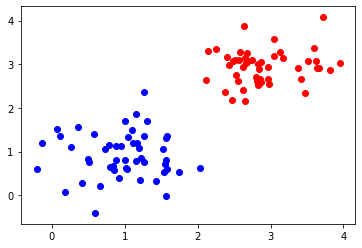

In [455]:

# generate 50 points from gaussian 1
x1 = generate_gaussian(M1, C1, NUM)
# labels
y1 = np.ones((x1.shape[0],))
# generate 50 points from gaussian 2
x2 = generate_gaussian(M2, C2, NUM)
y2 = -np.ones((x2.shape[0],))
# join
x = np.concatenate((x1, x2), axis = 0)
y = np.concatenate((y1, y2), axis = 0)
plot_data_with_labels(x, y)

# fit svm classifier
alphas = fit(x, y)

# get weights
w = np.sum(alphas * y[:, None] * x, axis = 0)
# get bias
cond = (alphas > 1e-4).reshape(-1)
b = y[cond] - np.dot(x[cond], w)
b = np.mean(b)

-2.272930966807286
6.343724115279827
[ 6.34372412  4.07079315  1.79786218 -0.47506879 -2.74799975 -5.02093072]


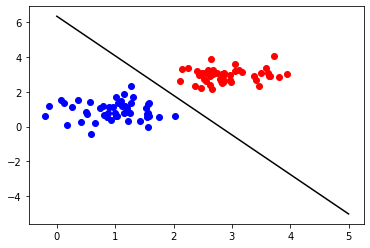

In [456]:
plot_data_with_line(x,y,w,b)

In [457]:
sigma = .5

def fitNonLinear(x, y): 
    global K
    global KC
    NUM = x.shape[0]
    DIM = x.shape[1]
    # we'll solve the dual
    # obtain the kernel
    K = y[:, None] * x
    Y = np.reshape(y, (NUM, 1))
    Ym = np.matmul(Y,Y.T)
    KC = np.dot(K, K.T)
    
    K = np.zeros((NUM,NUM))
    K = metrics.pairwise.rbf_kernel(x, x, sigma)
    K = np.multiply(K, Ym)
    P = matrix(K)
    q = matrix(-np.ones((NUM, 1)))
    G = matrix(-np.eye(NUM))
    h = matrix(np.zeros(NUM))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

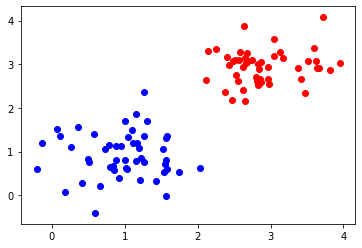

In [458]:
plot_data_with_labels(x, y)

# fit svm classifier
alphas = fitNonLinear(x, y)

cond = (alphas > 1e-4)
alpha_sv = alphas[cond]
n_sv = len(alpha_sv)
xCond = cond.reshape(-1)
x_sv = x[xCond, :]
y_sv = y[xCond]
K_sv = K[xCond,xCond]

b = np.mean(y_sv - K_sv*(np.multiply(alpha_sv, y_sv)))


In [459]:
n1 = 100
n2 = 100

x1plot = np.linspace(0,6, n1)
x2plot = np.linspace(0,6,n2)

[X1,X2] = np.meshgrid(x1plot,x2plot)

x1m = np.reshape(X1,n1*n2,1)
x2m = np.reshape(X2,n1*n2,1)
Xm = np.array([x1m, x2m]).T

ym = np.zeros((n1*n2,1))

for j in range(n1*n2):
    x_p = Xm[j]
    K_pred = metrics.pairwise.rbf_kernel([x_p], x_sv, sigma)
    ym[j] = np.sign(np.sum(np.multiply(np.multiply(alpha_sv,y_sv), K_pred)) + b)
    
yplot = np.reshape(ym, (n1, n2))

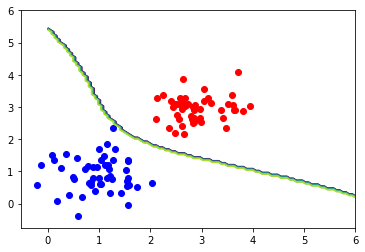

In [460]:
def plot_data_with_contour(x, y, x1P, x2P, yP):
    x1= np.arange(0,6);
    unique = np.unique(y)
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        plt.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])

    plt.contour(x1P, x2P, yP)
    plt.show()
    
plot_data_with_contour(x,y,x1plot, x2plot, yplot)

In [461]:
sigma = 3

def fitLS(x, y): 
    global K
    global KC
    NUM = x.shape[0]
    DIM = x.shape[1]
    # we'll solve the dual
    # obtain the kernel
    K = y[:, None] * x
    Y = np.reshape(y, (NUM, 1))
    Ym = np.matmul(Y,Y.T)
    KC = np.dot(K, K.T)
    
    K = np.zeros((NUM,NUM))
    K = metrics.pairwise.rbf_kernel(x, x, sigma)

    Omega = np.multiply(K, Ym)
    onev = np.ones((NUM, 1))
    gamma = 1
    
    yforA = np.reshape(y, (NUM, 1))
    
    A11 = np.zeros(1).reshape((1,1))
    A12 = yforA.T
    A21 = yforA
    A22 = Omega + np.eye(NUM)/gamma
    
    A1 = np.hstack((A11, A12))
    A2 = np.hstack((A21, A22))

    A =  np.vstack((A1, A2))
    
    B = np.vstack((A11, onev))
    
    sol = np.linalg.solve(A, B)
    b= sol[0]
    alpha=sol[1:]
    
    return {
        'b': b,
        'alphas': alpha
    }

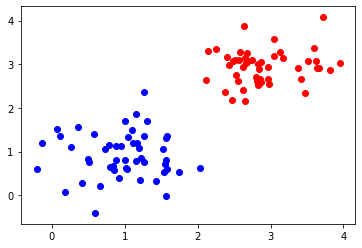

In [462]:
plot_data_with_labels(x, y)

# fit svm classifier
alphas = fitLS(x, y)

In [463]:
n1 = 100
n2 = 100

x1plot = np.linspace(0,6, n1)
x2plot = np.linspace(0,6,n2)

[X1,X2] = np.meshgrid(x1plot,x2plot)

x1m = np.reshape(X1,n1*n2,1)
x2m = np.reshape(X2,n1*n2,1)
Xm = np.array([x1m, x2m]).T

ym = np.zeros((n1*n2,1))

for j in range(n1*n2):
    x_p = Xm[j]
    K_pred = metrics.pairwise.rbf_kernel([x_p], x, sigma)
    ym[j] = np.sign(np.sum(np.multiply(np.multiply(alphas['alphas'],y), K_pred)) + alphas['b'])
    
yplot = np.reshape(ym, (n1, n2))

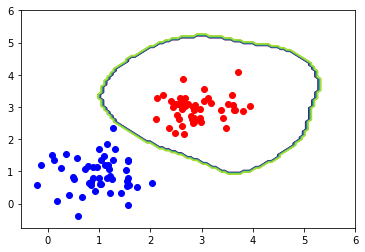

In [464]:
def plot_data_with_contour(x, y, x1P, x2P, yP):
    x1= np.arange(0,6);
    unique = np.unique(y)
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        plt.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])

    plt.contour(x1P, x2P, yP)
    plt.show()
    
plot_data_with_contour(x,y,x1plot, x2plot, yplot)